# Bach Chorale Dataset Exploration

In this notebook, we'll explore the Bach chorale dataset and visualize some of its properties. The dataset consists of chorales created by Bach represented as piano note indices, where each chorale is 100 to 640 time steps long, and each time step contains 4 integers representing the notes played by the four voices (soprano, alto, tenor, bass).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

import importlib
import src.data.loader
importlib.reload(src.data.loader)

# Add the parent directory to the path to import our modules
sys.path.append(os.path.abspath('..'))

from src.data.loader import BachChoraleLoader
importlib.reload(src.data.augmentation)
from src.data.augmentation import BachChoraleAugmenter

# Set up plotting
plt.style.use('ggplot')
sns.set_theme()
plt.rcParams['figure.figsize'] = (12, 8)

## Load the Dataset

First, let's load the Bach chorale dataset using our data loader.

In [42]:
import os

# Get the directory where this notebook is located
notebook_dir = os.path.dirname(os.path.abspath('__file__'))

# Now create a path relative to the notebook location
DATA_DIR = os.path.normpath(os.path.join(notebook_dir, '../src/data/bach_chorales'))

print(f"Using data directory: {DATA_DIR}")

# Initialize the loader with this path
loader = BachChoraleLoader(DATA_DIR)

# Load the datasets
train_chorales = loader.load_dataset('train')
val_chorales = loader.load_dataset('val')
test_chorales = loader.load_dataset('test')

Using data directory: c:\Users\George\Projects\Personal\Bach-Chorale-RNN\src\data\bach_chorales
Loaded 229 chorales from train split
Loaded 76 chorales from val split
Loaded 77 chorales from test split


## Examine Dataset Statistics

Let's compute and visualize some statistics about the dataset.

In [43]:
# Get dataset statistics
train_stats = loader.get_dataset_stats(train_chorales)
val_stats = loader.get_dataset_stats(val_chorales)
test_stats = loader.get_dataset_stats(test_chorales)

# Print statistics
print(f"Training set:")
print(f"  Number of chorales: {train_stats['num_chorales']}")
print(f"  Total time steps: {train_stats['total_time_steps']}")
print(f"  Min/Max/Avg length: {train_stats['min_length']}/{train_stats['max_length']}/{train_stats['avg_length']:.2f}")
print(f"  Note range: {train_stats['note_range']}")
print(f"\nValidation set:")
print(f"  Number of chorales: {val_stats['num_chorales']}")
print(f"\nTest set:")
print(f"  Number of chorales: {test_stats['num_chorales']}")

Training set:
  Number of chorales: 229
  Total time steps: 55457
  Min/Max/Avg length: 101/517/242.17
  Note range: (36.0, 81.0)

Validation set:
  Number of chorales: 76

Test set:
  Number of chorales: 77


## Visualize Chorale Lengths

Let's visualize the distribution of chorale lengths in the training set.

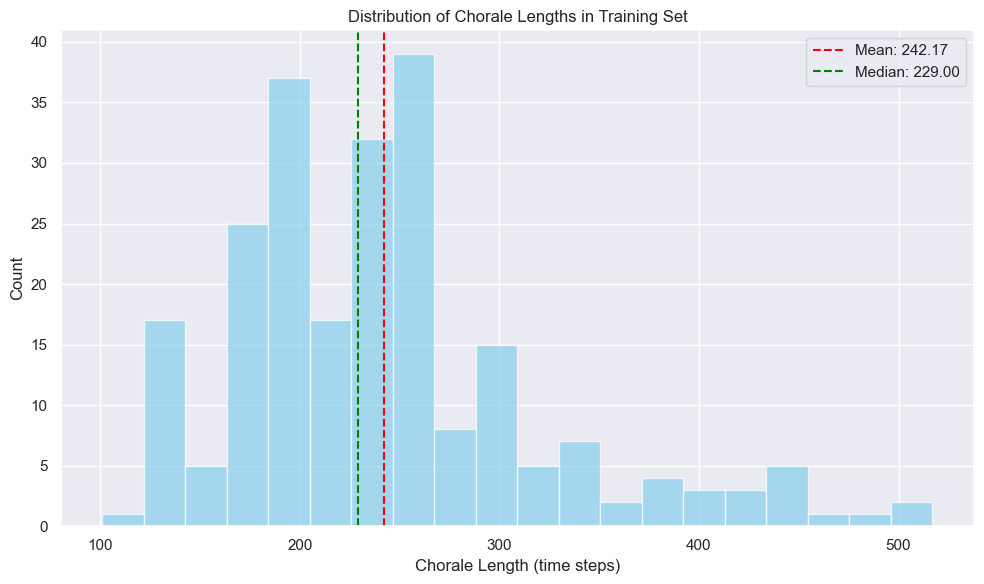

In [44]:
# Get chorale lengths
train_lengths = [chorale.shape[0] for chorale in train_chorales]

plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=20, alpha=0.7, color='skyblue')
plt.axvline(np.mean(train_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(train_lengths):.2f}')
plt.axvline(np.median(train_lengths), color='green', linestyle='--', label=f'Median: {np.median(train_lengths):.2f}')
plt.xlabel('Chorale Length (time steps)')
plt.ylabel('Count')
plt.title('Distribution of Chorale Lengths in Training Set')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualize Note Distribution

Let's visualize the distribution of note values for each voice.

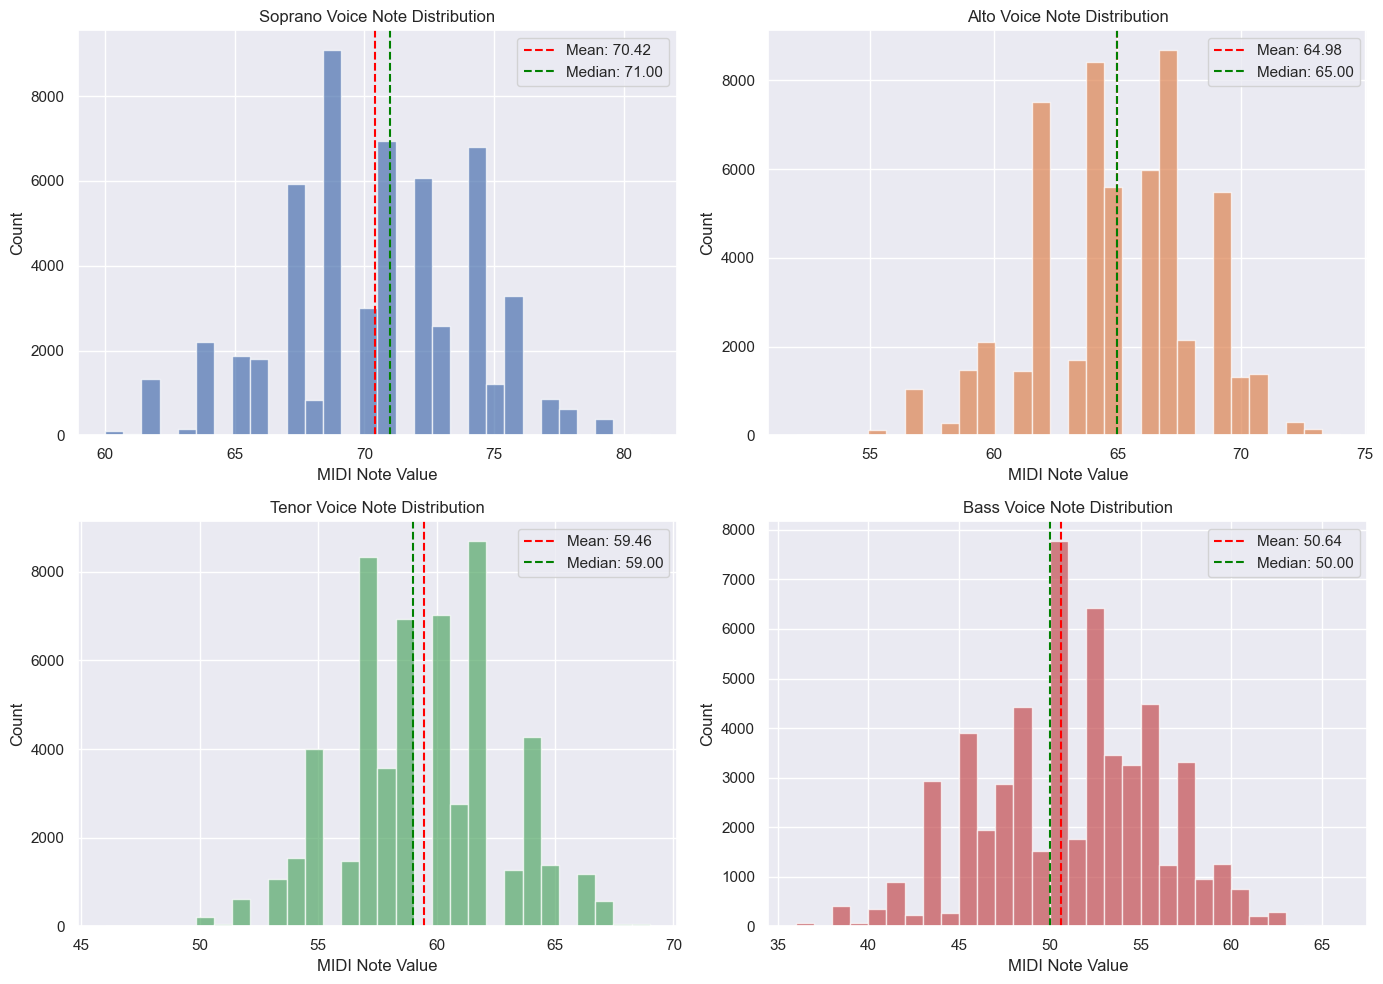

In [45]:
# Collect notes for each voice
voice_notes = [[] for _ in range(4)]
for chorale in train_chorales:
    for i in range(4):
        # Only include non-zero notes
        notes = chorale[:, i]
        voice_notes[i].extend(notes[notes > 0])

voice_names = ['Soprano', 'Alto', 'Tenor', 'Bass']

# Plot note distribution for each voice
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, (notes, name) in enumerate(zip(voice_notes, voice_names)):
    axs[i].hist(notes, bins=30, alpha=0.7, color=f'C{i}')
    axs[i].set_title(f'{name} Voice Note Distribution')
    axs[i].set_xlabel('MIDI Note Value')
    axs[i].set_ylabel('Count')
    axs[i].grid(True)
    
    # Add mean and median lines
    axs[i].axvline(np.mean(notes), color='red', linestyle='--', label=f'Mean: {np.mean(notes):.2f}')
    axs[i].axvline(np.median(notes), color='green', linestyle='--', label=f'Median: {np.median(notes):.2f}')
    axs[i].legend()

plt.tight_layout()
plt.show()

## Visualize a Sample Chorale

Let's visualize a sample chorale to better understand the data.

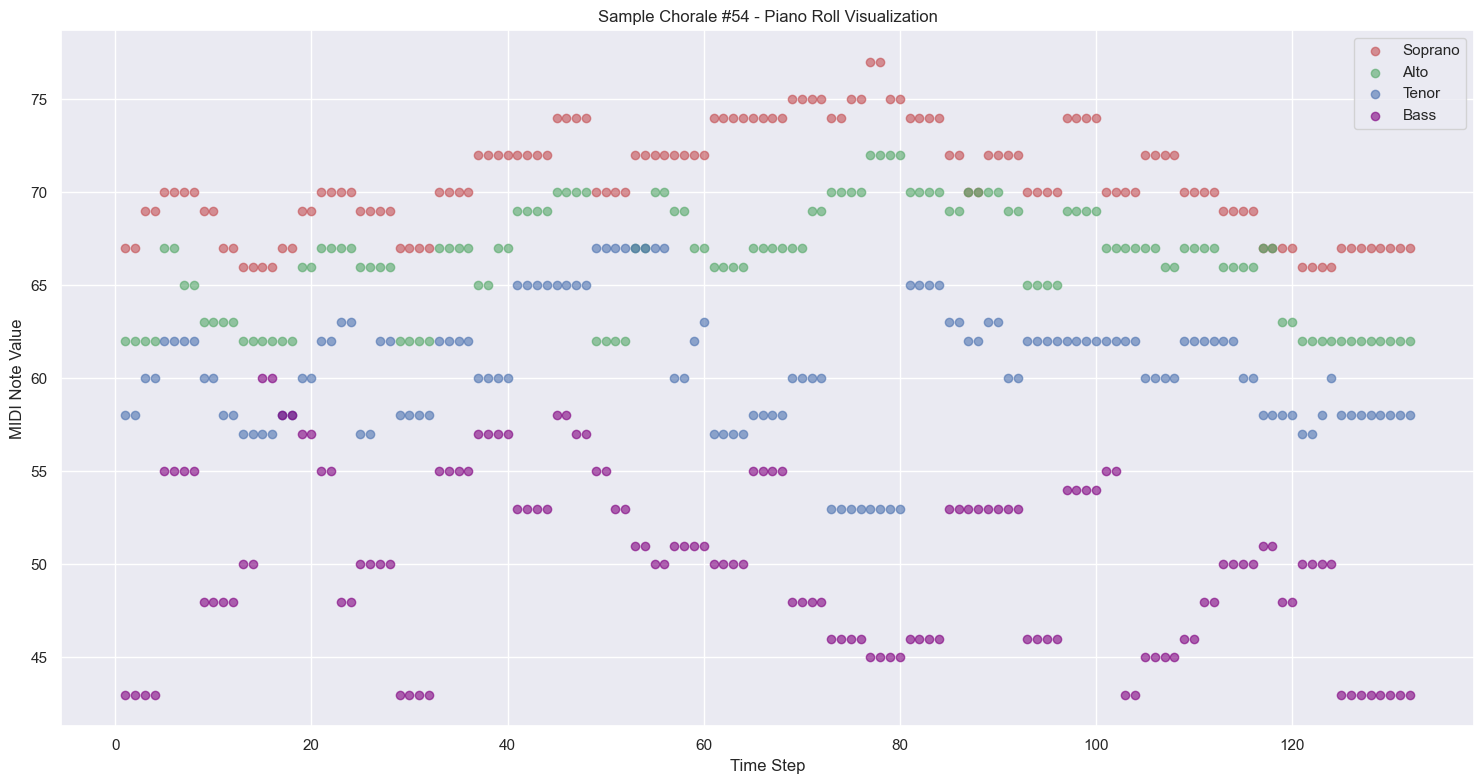

In [46]:
# Select a random chorale
sample_idx = np.random.randint(0, len(train_chorales))
sample_chorale = train_chorales[sample_idx]

# Create a piano roll visualization
plt.figure(figsize=(15, 8))

# Define colors for each voice
colors = ['r', 'g', 'b', 'purple']

for i in range(4):
    voice_data = sample_chorale[:, i]
    time_steps = np.arange(len(voice_data))
    
    # Filter out silence (note value 0)
    valid_indices = voice_data > 0
    valid_time_steps = time_steps[valid_indices]
    valid_notes = voice_data[valid_indices]
    
    plt.scatter(valid_time_steps, valid_notes, color=colors[i], alpha=0.6, label=voice_names[i])

plt.xlabel('Time Step')
plt.ylabel('MIDI Note Value')
plt.title(f'Sample Chorale #{sample_idx} - Piano Roll Visualization')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Test Data Augmentation

Let's test our data augmentation strategies.

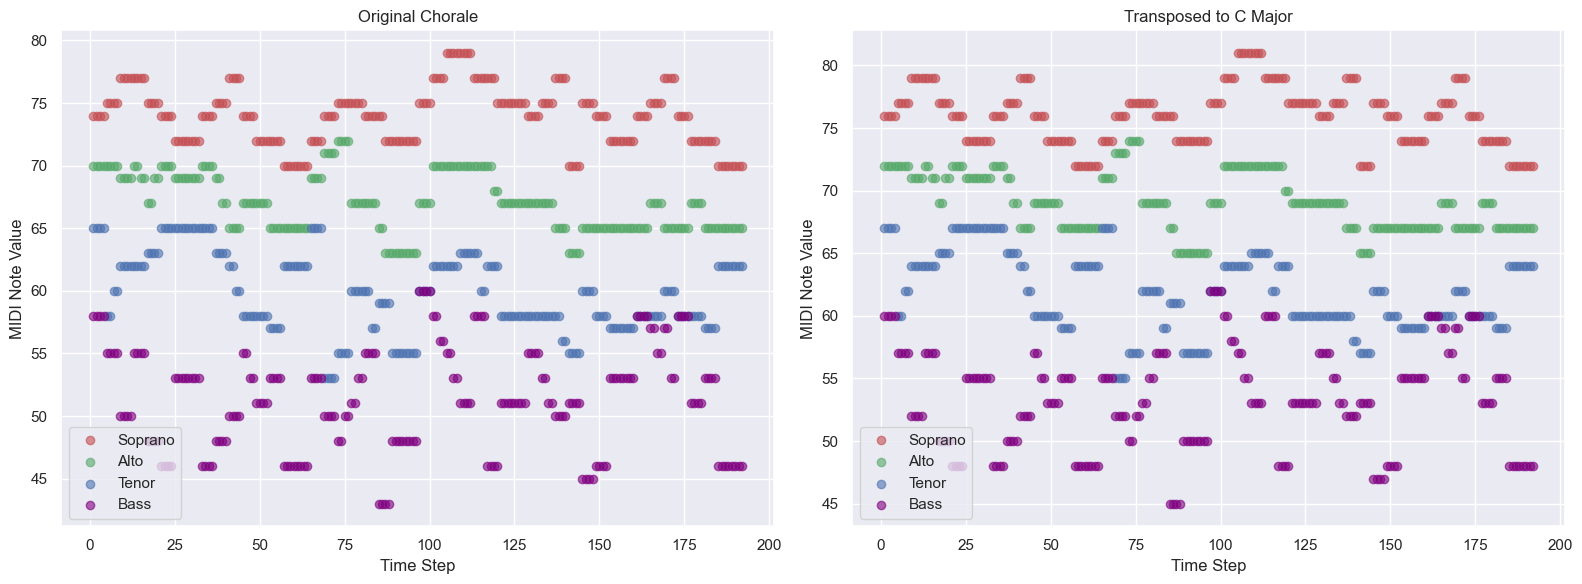

In [47]:
# Initialize the augmenter
augmenter = BachChoraleAugmenter()

# Select a sample chorale for demonstration
sample_chorale = train_chorales[0]

# Transpose to C major
c_major_chorale = augmenter.normalize_to_c_major([sample_chorale])[0]

# Visualize original vs. transposed
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original chorale
for i in range(4):
    voice_data = sample_chorale[:, i]
    time_steps = np.arange(len(voice_data))
    valid_indices = voice_data > 0
    valid_time_steps = time_steps[valid_indices]
    valid_notes = voice_data[valid_indices]
    ax1.scatter(valid_time_steps, valid_notes, color=colors[i], alpha=0.6, label=voice_names[i])

ax1.set_xlabel('Time Step')
ax1.set_ylabel('MIDI Note Value')
ax1.set_title('Original Chorale')
ax1.legend()
ax1.grid(True)

# Transposed chorale
for i in range(4):
    voice_data = c_major_chorale[:, i]
    time_steps = np.arange(len(voice_data))
    valid_indices = voice_data > 0
    valid_time_steps = time_steps[valid_indices]
    valid_notes = voice_data[valid_indices]
    ax2.scatter(valid_time_steps, valid_notes, color=colors[i], alpha=0.6, label=voice_names[i])

ax2.set_xlabel('Time Step')
ax2.set_ylabel('MIDI Note Value')
ax2.set_title('Transposed to C Major')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Compare Augmentation Versions

Let's compare the dataset sizes for each augmentation version.

In [48]:
# Use a small subset for quick demonstration
small_subset = train_chorales[:5]

# Get augmented datasets
version1 = augmenter.get_augmented_dataset(small_subset, version=1)
version2 = augmenter.get_augmented_dataset(small_subset, version=2)
version3 = augmenter.get_augmented_dataset(small_subset, version=3)
version4 = augmenter.get_augmented_dataset(small_subset, version=4)

# Compare dataset sizes
print(f"Version 1 (Original): {len(version1)} chorales")
print(f"Version 2 (C major): {len(version2)} chorales")
print(f"Version 3 (C, G, F + tempo): {len(version3)} chorales")
print(f"Version 4 (All 12 keys): {len(version4)} chorales")

Version 1 (Original): 5 chorales
Version 2 (C major): 5 chorales
Version 3 (C, G, F + tempo): 45 chorales
Version 4 (All 12 keys): 60 chorales


## Prepare Sequences for Training

Finally, let's prepare sequences for training an LSTM model.

In [49]:
# Define sequence length
sequence_length = 16

# Prepare sequences for each augmentation version
X_v1, y_v1 = loader.prepare_sequences(version1, sequence_length)
X_v2, y_v2 = loader.prepare_sequences(version2, sequence_length)
X_v3, y_v3 = loader.prepare_sequences(version3, sequence_length)
X_v4, y_v4 = loader.prepare_sequences(version4, sequence_length)

print(f"Version 1: {X_v1.shape[0]} sequences")
print(f"Version 2: {X_v2.shape[0]} sequences")
print(f"Version 3: {X_v3.shape[0]} sequences")
print(f"Version 4: {X_v4.shape[0]} sequences")

Version 1: 1245 sequences
Version 2: 1245 sequences
Version 3: 19155 sequences
Version 4: 14940 sequences


## Conclusion

In this notebook, we explored the Bach chorale dataset and visualized some of its properties. We also tested our data augmentation strategies and prepared sequences for training an LSTM model. In the next notebook, we'll train and evaluate the model.